### Task 2

In this task you will work with time series data to create a forecasting model. You will 
- Preprocess the data and create slices
- Build the model and train it on your data
- Repeat the above for these values of sequence length `(5, 10, 15)`
- Think of some quantitative or qualitative way to compare the **fit** (prediction on train set) along with the **forecasting** capability (prediction on test set) and provide your conclusions at the end.

The data generation and prediction code has been given to you. 

*Correct output plots are shown in the notebook already.*

In [136]:
!reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from tqdm import tqdm
import os
from datetime import datetime
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Input, Dense, LSTM, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger, Callback
import keras.backend as K
from sklearn.metrics import mean_absolute_error

### The Data

We will be generating synthetic time-series data since real data of this kind has a lot of noise and would require considerable management and training to achieve decent predictions.

You can imagine this data is about the sales of a product or global average temperatures over time. 

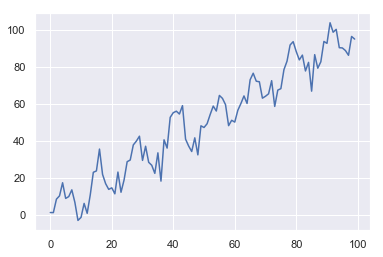

In [137]:
def dither(v):
    return np.random.normal(loc=v, scale=5)

np.random.seed(43)
x = np.arange(100)
y = x + 10*np.sin(0.5*x)
data = np.array([dither(v) for v in y])
plt.plot(data);

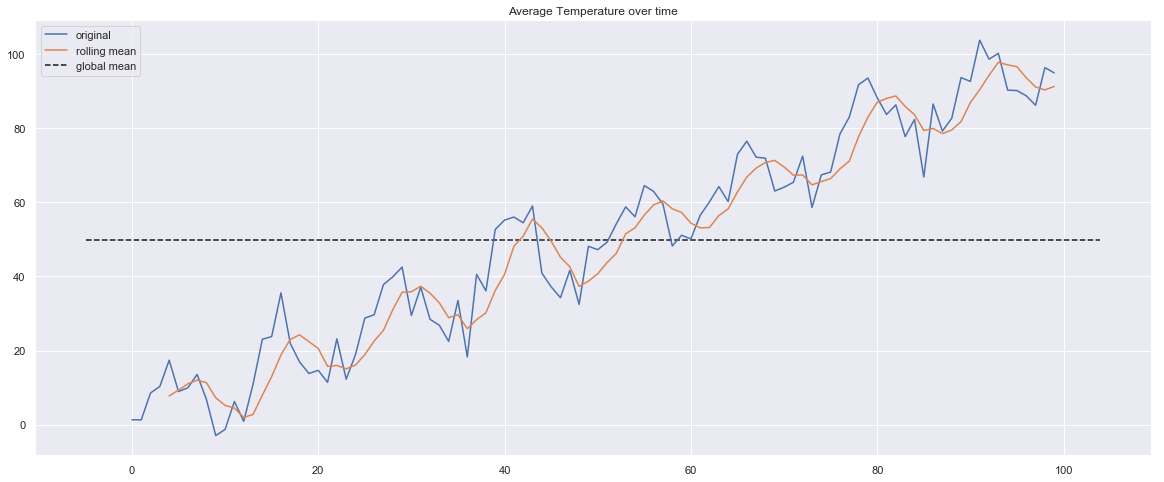

In [138]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(data, label='original');
ax.plot(pd.Series(data).rolling(5).mean(), label='rolling mean');
ax.hlines([data.mean()], ax.get_xlim()[0], ax.get_xlim()[1], 
          color='k', linestyle='dashed', label='global mean');
ax.legend();
ax.set_title('Average Temperature over time');

The data has both short-term (seasonality) and long-term (trend) patterns but there is also a lot of noise. This is why you will often see time series handled as a **stochastic process** (one involving random variables). The dashed black line is the global mean shown as a reference value to judge peaks and dips against. 

The orange line is a smoothed curve which follows the same trends as the blue curve. This is called the **rolling mean**. This is the result of convolving the signal (blue curve) with a 1D mean blur kernel.  

This is not a **stationary** time-series and we will not be concerned with this issue during this assignment. 

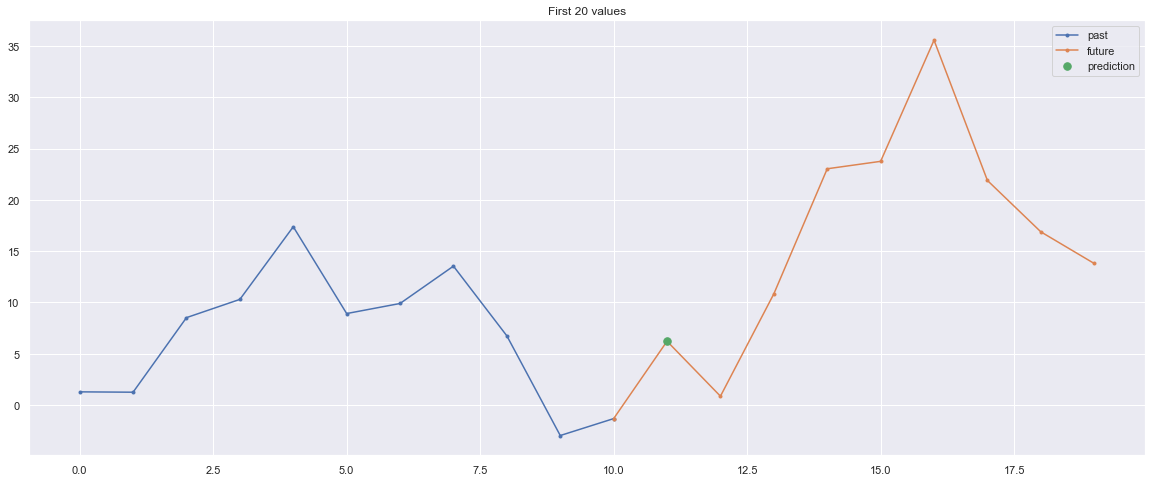

In [139]:
fig, ax = plt.subplots(figsize=(20,8))
chunk = data[:20]
ax.plot(np.arange(0,11), chunk[:11], '.-', label='past');
ax.plot(np.arange(10,20), chunk[10:], '.-', label='future');
ax.plot([11], chunk[11], '.', markersize=15, label='prediction');
ax.legend();
ax.set_title('First 20 values');

Zooming into the first 20 values we can much more easily see the individual data points. The blue line is considered the past and the green line is the future. In this setup we have to make predictions in the future based on patterns we have learned from the past. We accomplish this by using a **slice** of data as input to our model and predict the very next value (green dot). We keep doing this until we have all the predictions. 

In [140]:
data.shape

(100,)

We can't randomly split the data into training and testing sets. Both sets have to be contiguous in time otherwise we are basically destroying the data. 

Let's split the data so that about half the series is in the past and half is in the future where we will make predictions. I this framework the past is our training set and the future is our test set.

In [141]:
train = data[:50]
test  = data[50:]

In [142]:
data.min(), data.mean(), data.max()

(-2.9713754609891403, 49.84289209763272, 103.8306061991388)

### Processing

In [143]:
def make_slices(series, window):
    num_rows = len(series)
    num_slices = num_rows - window +1
    print("slices are: ", num_slices)
    slices = np.zeros((int(num_slices), (window-1)))
#     print(slices.shape)
    # fill your code
    for i in range(num_slices):
        slices[i]=series[i:(i+window-1)]
    return slices

The `sequence_len` hyperparameter controls how far in the past the model can see in order to predict the future. The `num_feats` parameter is the number of distinct features we are inputting into the model. For now we just have one variable which we are learning from so it is set equal to 1. 

We can have multiple input and output features from a recurrent model.

In [144]:
sequence_len =5
num_feats = 1

In [145]:
train_slices = make_slices(train, sequence_len+1)
num_slices=train_slices.shape[0]
print(num_slices)

slices are:  45
45


In [146]:
train_slices.shape

(45, 5)

In [147]:
train_x = train_slices.reshape(train_slices.shape+(1,))
train_y = np.zeros(train_slices.shape[0])

for i in range(1,num_slices):        #Populating the train_y in python
    train_y[i-1]=train_x[i,-1,0]

train_x.shape, train_y.shape

((45, 5, 1), (45,))

Let's make sure the `make_slices` function works correctly.

In [148]:
(train_x[1:,-1,0] == train_y[:-1]).all()

True

### The Model

In [101]:
model_name = f"lstm_{sequence_len}"
if not os.path.exists(model_name):
    os.mkdir(model_name)


In [175]:
## Add your code for you model here
model = Sequential()
model.add(LSTM(80, input_shape=(sequence_len,1),return_sequences=False))
# model.add(Dropout(0.2))
model.add(Dense(1))


In [176]:
adam = Adam(lr=0.01)
model.compile(optimizer=adam, 
              loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 80)                26240     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 81        
Total params: 26,321
Trainable params: 26,321
Non-trainable params: 0
_________________________________________________________________


In [184]:
batch_size=1
class LRTensorBoard(TensorBoard):
    def __init__(self, *args, **kwargs):
        super(LRTensorBoard, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({'lr': K.eval(self.model.optimizer.lr)})
        super(LRTensorBoard, self).on_epoch_end(epoch, logs)

class PrintDot(Callback):
    def __init__(self, *args, **kwargs):
        super(PrintDot, self).__init__(*args, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        print('.', end='')
        if epoch % 50 == 0:
            print('epoch:' , epoch, ', loss: ', logs['loss'], ', lr: ', logs['lr'])
        super(PrintDot, self).on_epoch_end(epoch, logs)

checkpoint = ModelCheckpoint(model_name+'/'+model_name+'.h5', 
                             monitor='loss', verbose=0, save_best_only=True, mode='auto')
cvslogger = CSVLogger(model_name+'/logs.csv', separator=',', append=True)
reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-10)
tensorboard = LRTensorBoard(log_dir='./'+model_name, histogram_freq=0, write_graph=True, write_grads=1, 
                            batch_size=batch_size, write_images=True)
printdot = PrintDot()

callbacks = [checkpoint, tensorboard, cvslogger, reducelr, printdot]

In [185]:
hist = model.fit(train_x, train_y, epochs=150, callbacks=callbacks, verbose=1)

Epoch 1/150
45/45 [==============================] - 0s 747us/step - loss: 28.9584
.epoch: 0 , loss:  28.958417828877767 , lr:  0.0009999999
Epoch 2/150
45/45 [==============================] - 0s 823us/step - loss: 28.8938
.Epoch 3/150
45/45 [==============================] - 0s 780us/step - loss: 28.8397
.Epoch 4/150
45/45 [==============================] - 0s 698us/step - loss: 28.8837
.Epoch 5/150
45/45 [==============================] - 0s 718us/step - loss: 28.6599
.Epoch 6/150
45/45 [==============================] - 0s 748us/step - loss: 28.7092
.Epoch 7/150
45/45 [==============================] - 0s 1ms/step - loss: 28.8605
.Epoch 8/150
45/45 [==============================] - 0s 976us/step - loss: 28.8813
.Epoch 9/150
45/45 [==============================] - 0s 1ms/step - loss: 28.7660
.Epoch 10/150
45/45 [==============================] - 0s 1ms/step - loss: 28.6664
.Epoch 11/150
45/45 [==============================] - 0s 1ms/step - loss: 28.5386
.Epoch 12/150
45/45 [=====

In [186]:
# model.load_weights(model_name+'/'+model_name+'.h5')

### Making Predictions

Let's check how the model does with the training data.

In [187]:
train_y[4]

-2.9713754609891403

In [188]:
model.predict(train_x[4].reshape(1,sequence_len,num_feats))[0][0]

-3.3044

Now let's make proper predictions using slices of training data.

In [189]:
num_preds=num_slices
train_compare = []
d0 = train_x[0,:,0]
for i in tqdm(range(num_preds)):
    d0 = d0.reshape(1,sequence_len,num_feats)
    pred = model.predict(d0)[0][0]
    print(pred)
    train_compare.append(pred)
    d0 = np.append(d0[-1,1:,:], pred)

100%|██████████| 45/45 [00:00<00:00, 229.03it/s]

8.922114
9.903186
13.409484
6.6362267
-3.3668528
-1.3173785
6.209172
0.9831606
11.377902
23.513618
24.247154
36.602585
22.669872
24.101742
20.940819
24.403706
34.060806
42.74303
45.744408
48.51516
44.840813
45.622562
44.435387
44.751133
43.18202
42.53542
40.87738
39.29473
36.28707
32.0826
26.025124
21.395565
21.015083
22.545246
26.405216
35.59325
41.67099
47.565384
43.963608
42.495598
41.100666
40.344414
37.422165
33.7344
28.452091


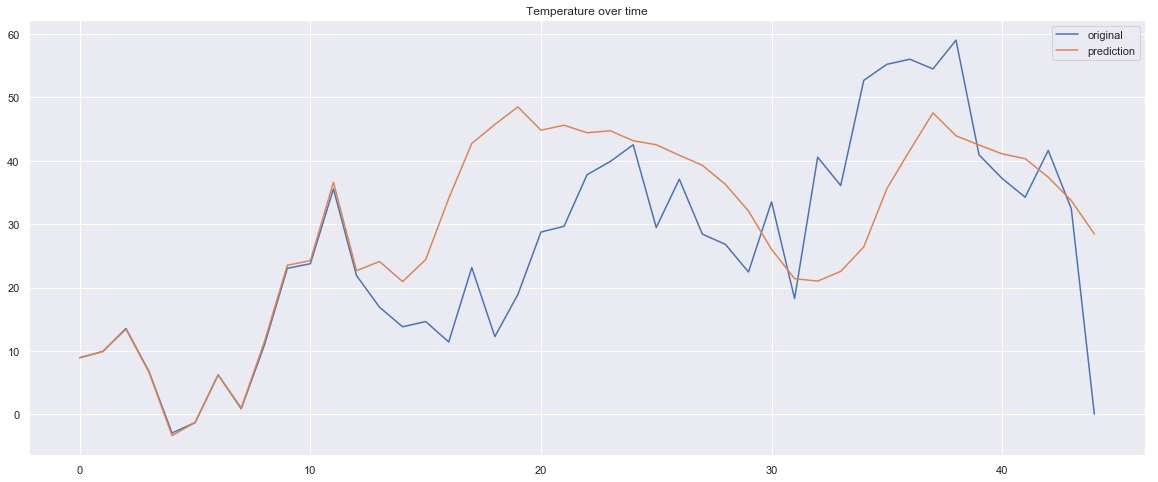

In [190]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(train_y, label='original');
ax.plot(train_compare, label='prediction');
ax.legend();
ax.set_title('Temperature over time');

We can see the model has picked up on both the seasonality as well as the trend. 

Now let's do the same thing for test data. This is the **forecasting** stage. 

In [193]:
num_preds=40
d0 = np.append(train_x[-1,1:,:], train_y[-1])
print(num_preds)
test_compare = []
for i in tqdm(range(num_preds)):
    d0 = d0.reshape(1,sequence_len,num_feats)
    pred = model.predict(d0)[0][0]
    test_compare.append(pred)
    d0 = np.append(d0[-1,1:,:], pred)

100%|██████████| 40/40 [00:00<00:00, 237.59it/s]

40


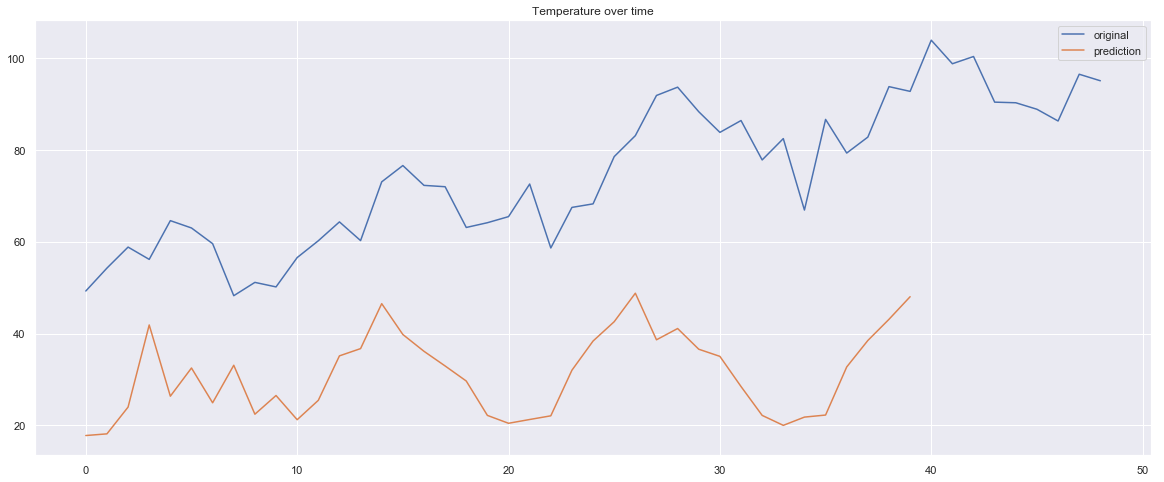

In [194]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(test.tolist()[1:], label='original');
ax.plot(test_compare, label='prediction');
ax.legend();
ax.set_title('Temperature over time');

Again, the model is working very decently.  

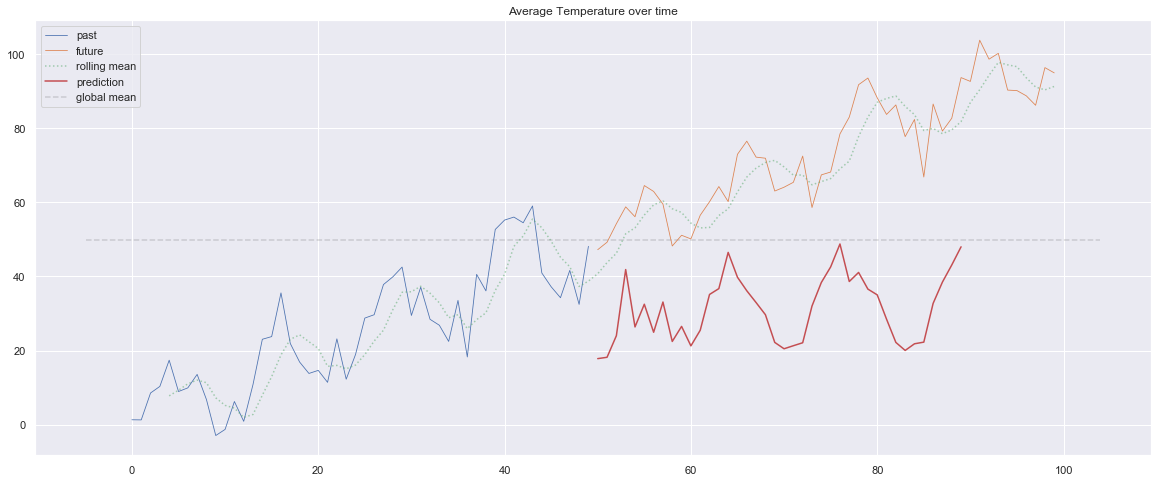

In [195]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(np.arange(0,50), train, linewidth=0.8, label='past');
ax.plot(np.arange(50,100), test, linewidth=0.8, label='future');
ax.plot(pd.Series(data).rolling(5).mean(), 
        alpha=0.5, linestyle='dotted', label='rolling mean');
ax.plot(np.arange(50,90), test_compare, label='prediction');
ax.hlines([data.mean()], ax.get_xlim()[0], ax.get_xlim()[1], 
          color='grey', alpha=0.3, linestyle='dashed', label='global mean');
ax.legend();
ax.set_title('Average Temperature over time');

In [ ]:
The train model doesnot give very good result because of the window size. When it tries to incorporate the whole window data 
for the prediction it tends to smooth out. 